In [2]:
#@title Code: Import Dependencies {display-mode: "form"}

# This code will be hidden when the notebook is loaded.

!pip install dask[bag] --upgrade > /dev/null
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import ast
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Activation, Input, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from tqdm import tqdm
from glob import glob
from PIL import Image, ImageDraw, ImageOps
from dask import bag
start = dt.datetime.now()

Using TensorFlow backend.


In [0]:
#@title Code: Retrieve Data from Google Drive {display-mode: "form"}

# This code will be hidden when the notebook is loaded.

!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def download_drive_dir(local_dir, folder_id, whitelist=[]):
    """
    params:
        local_dir: Colaboratory directory
        folder_id: Google Drive folder ID
    """
    local_download_path = os.path.expanduser(local_dir) 
    try:
        os.makedirs(local_download_path)
    except Exception as e:
        print('Error creating path:', e)

    file_list = drive.ListFile(
        {'q': "'{}' in parents".format(folder_id)}).GetList()

    for f in tqdm(file_list):
        if whitelist and f['title'] in whitelist:
            # print('title: %s, id: %s' % (f['title'], f['id']))
            fname = os.path.join(local_download_path, f['title'])
            # print('downloading to {}'.format(fname))
            f_ = drive.CreateFile({'id': f['id']})
            f_.GetContentFile(fname)

In [4]:
download_drive_dir('./input/shuffle-csvs', '1H8ogDcbBGsgAJkxaOxXd-XR3ZH14su3i')

100%|██████████| 100/100 [00:00<00:00, 70374.23it/s]


In [39]:
CATLIST = ["car.csv"]
download_drive_dir('./input/train-simplified', '1ChgkDM2cfJF-WqLqK2untxOl_2vD5WfT', CATLIST)

Error creating path: [Errno 17] File exists: './input/train-simplified'


100%|██████████| 340/340 [00:01<00:00, 249.59it/s]


In [0]:
valfrac = 0.1
num_classes = len(CATLIST)
classfiles = os.listdir('./input/train-simplified')
numstonames = {i: v[:-4].replace(" ", "_") for i, v in enumerate(classfiles)}
imheight, imwidth = 28, 28
ims_per_class = 100000

In [40]:
#@title Code: Generate Data - Few Categories - X_train, X_val
# Conversion to image from sequence

import cv2 as cv

def draw_it(strokes):
    image = Image.new("P", (259,259), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=6)
    res = cv.resize(np.array(image), (imheight, imwidth), interpolation=cv.INTER_AREA)
    return res/255.

# Get training and testing data
train_grand = []
class_paths = glob('./input/train-simplified/*.csv')
for i,c in enumerate(tqdm(class_paths[0: num_classes])):
    
    train = pd.read_csv(c, usecols=['drawing', 'recognized'], nrows=ims_per_class*5//4)
    train = train[train.recognized == True].head(ims_per_class)
    imagebag = bag.from_sequence(train.drawing.values).map(draw_it)
    
    trainarray = np.array(imagebag.compute()) 
    trainarray = np.reshape(trainarray, (ims_per_class, -1))    
    labelarray = np.full((train.shape[0], 1), i)
    trainarray = np.concatenate((labelarray, trainarray), axis=1)
    train_grand.append(trainarray)
    
train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)])
train_grand = train_grand.reshape((-1, (imheight*imwidth+1)))

del trainarray
del train

cutpt = int(valfrac * train_grand.shape[0])

np.random.shuffle(train_grand)
y_train, X_train = train_grand[cutpt: , 0], train_grand[cutpt: , 1:]
y_val, X_val = train_grand[0:cutpt, 0], train_grand[0:cutpt, 1:]

del train_grand

y_train = keras.utils.to_categorical(y_train, num_classes)
X_train = X_train.reshape(X_train.shape[0], imheight, imwidth, 1)
y_val = keras.utils.to_categorical(y_val, num_classes)
X_val = X_val.reshape(X_val.shape[0], imheight, imwidth, 1)

print(y_train.shape, "\n",
      X_train.shape, "\n",
      y_val.shape, "\n",
      X_val.shape)

100%|██████████| 1/1 [01:26<00:00, 86.26s/it]


(90000, 1) 
 (90000, 28, 28, 1) 
 (10000, 1) 
 (10000, 28, 28, 1)


In [0]:
DP_DIR = './input/shuffle-csvs/'
INPUT_DIR = './input/'
BASE_SIZE = 256
NCSVS = 100
NCATS = 340
np.random.seed(seed=1987)
tf.set_random_seed(seed=1987)

In [0]:
#@title Code: Define Metrics {display-mode: "form"}

# This code will be hidden when the notebook is loaded.

def f2cat(filename):
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR, 'train_simplified'))
    return sorted([f2cat(f) for f in files], key=str.lower)

def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:
STEPS = 100
EPOCHS = 15
size = 28
batchsize = 512

In [0]:
#@title Code: Image generator
def draw_cv2(raw_strokes, size=256, lw=12, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def image_generator_xd(size, batchsize, ks, lw=12, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(ast.literal_eval)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                x = preprocess_input(x).astype(np.float32)
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield x, x

def df_to_image_array_xd(df, size, lw=12, time_color=True):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x

In [0]:
valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=6000)
x_valid = df_to_image_array_xd(valid_df, size)
y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

In [0]:
train_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS - 1))

In [0]:
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.models import Model
from keras.layers import Reshape
from keras import backend as K
from keras import objectives

In [0]:
#@title conv_autoencoder_1
def conv_autoencoder_1(size):
    input_img = Input(shape=(size, size, 1))  # adapt this if using `channels_first` image data format

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    encoding = Dense(10)(x)
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional
    x = Dense(128)(encoding)
    x = Reshape(target_shape=(4, 4, 8))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    encoder = Model(input_img, encoding)
    autoencoder = Model(input_img, decoded)
    
    return encoder, autoencoder

In [0]:
def conv_autoencoder_2(size):
    input_img = Input(shape=(size, size, 1))  # adapt this if using `channels_first` image data format
    x = Conv2D(64, (7, 7), activation='relu', padding='same')(input_img)
    x = Conv2D(64, (7, 7), activation='relu', padding='same')(x)
    x = Conv2D(64, (7, 7), strides=(2,2), activation='relu', padding='same')(x) # 12 x 12 x 32
    x = Conv2D(32, (5, 5), strides=(2,2), activation='relu', padding='same')(x) # 12 x 12 x 32
    x = Conv2D(16, (3, 3), strides=(2,2), activation='relu', padding='same')(x) # 4 x 4 x 16
    x = Flatten()(x)
    encoding = Dense(10)(x)
    x = Dense(784)(encoding)
    x = Reshape(target_shape=(7, 7, 16))(x)
    x = Conv2DTranspose(16, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
    x = Conv2DTranspose(32, (5, 5), strides=(2,2), activation='relu', padding='same')(x)
    x = Conv2DTranspose(64, (7, 7), strides=(2,2), activation='relu', padding='same')(x)
    x = Conv2DTranspose(64, (7, 7), activation='relu', padding='same')(x)
    x = Conv2DTranspose(64, (7, 7), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    
    encoder = Model(input_img, encoding)
    autoencoder = Model(input_img, decoded)
    
    return encoder, autoencoder

In [0]:
batch_size = batchsize
original_dim = 28*28
latent_dim = 128

def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def variational_autoencoder(size):
    input_img = Input(shape=(size, size, 1))
    x = Conv2D(4, (2, 2), activation='relu', padding='same')(input_img)
    x = Conv2D(4, (2, 2), activation='relu', padding='same')(x)
#     x = Conv2D(4, (2, 2), strides=(2,2), activation='relu', padding='same')(x)
    x = Conv2D(8, (2, 2), activation='relu', padding='same')(x)
    x = Conv2D(8, (2, 2), activation='relu', padding='same')(x)
    x = Conv2D(8, (5, 5), strides=(2,2), activation='relu', padding='same')(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    z_mean = Dense(latent_dim)(x)
    z_log_sigma = Dense(latent_dim)(x)

    # note that "output_shape" isn't necessary with the TensorFlow backend
    # so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

    def decoder_convs(x):
        x = Dense(256, activation='relu')(x)
        x = Dense(original_dim)(x)
        x = Reshape(target_shape=(7, 7, 16))(x)
        x = Conv2DTranspose(8, (5, 5), strides=(2,2), activation='relu', padding='same')(x)
        x = Conv2D(8, (2, 2), activation='relu', padding='same')(x)
        x = Conv2D(8, (2, 2), activation='relu', padding='same')(x)
        x = Conv2DTranspose(4, (2, 2), strides=(2,2), activation='relu', padding='same')(x)
        x = Conv2D(4, (2, 2), activation='relu', padding='same')(x)
        x = Conv2D(4, (2, 2), activation='relu', padding='same')(x)
        x = Conv2D(1, (2, 2), activation='sigmoid', padding='same')(x)
        x = Reshape(target_shape=(28, 28, 1))(x)
        return x
    
    x_decoded_mean = decoder_convs(z)
    
    # end-to-end autoencoder
    vae = Model(input_img, x_decoded_mean)

    # encoder, from inputs to latent space
    encoder = Model(input_img, z_mean)

    # generator, from latent space to reconstructed inputs
    decoder_input = Input(shape=(latent_dim,))
    _x_decoded_mean = decoder_convs(decoder_input)
    generator = Model(decoder_input, _x_decoded_mean)
    
    def vae_loss(x, x_decoded_mean):
        xent_loss = K.mean(objectives.binary_crossentropy(x, x_decoded_mean), axis=(1, 2))
        print(xent_loss.shape)
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
        print(kl_loss.shape)
        return xent_loss + kl_loss

    return vae, encoder, generator, vae_loss

In [0]:
vae, encoder, generator, vae_loss = variational_autoencoder(size)
vae.compile(optimizer=keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0), loss=vae_loss)

In [0]:
vae.fit(X_train, X_train, epochs=120, batch_size=512, shuffle=True, validation_data=(X_val, X_val))

In [24]:
#@title Code: Import MNIST Data - x_train, x_test
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

11493376/11490434 [==============================] - 1s 0us/step


In [27]:
vae.fit(x_train, x_train, epochs=120, batch_size=512, shuffle=True, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/120
60000/60000 [==============================] - 7s 109us/step - loss: 0.3539 - val_loss: 0.2934
Epoch 2/120
60000/60000 [==============================] - 5s 88us/step - loss: 0.2737 - val_loss: 0.2586
Epoch 3/120
60000/60000 [==============================] - 5s 87us/step - loss: 0.2542 - val_loss: 0.2513
Epoch 4/120
60000/60000 [==============================] - 5s 87us/step - loss: 0.2499 - val_loss: 0.2477
Epoch 5/120
60000/60000 [==============================] - 5s 87us/step - loss: 0.2450 - val_loss: 0.2414
Epoch 6/120
60000/60000 [==============================] - 5s 88us/step - loss: 0.2391 - val_loss: 0.2389
Epoch 7/120
60000/60000 [==============================] - 5s 88us/step - loss: 0.2344 - val_loss: 0.2340
Epoch 8/120
60000/60000 [==============================] - 5s 88us/step - loss: 0.2312 - val_loss: 0.2317
Epoch 9/120
60000/60000 [==============================] - 5s 88us/step - loss: 0.2285 - val_loss: 0.

In [30]:
vae.fit(x_train, x_train, epochs=120, batch_size=512, shuffle=True, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/120
60000/60000 [==============================] - 5s 91us/step - loss: 0.2108 - val_loss: 0.2099
Epoch 2/120
60000/60000 [==============================] - 5s 89us/step - loss: 0.2109 - val_loss: 0.2107
Epoch 3/120
60000/60000 [==============================] - 5s 88us/step - loss: 0.2109 - val_loss: 0.2106
Epoch 4/120
60000/60000 [==============================] - 5s 88us/step - loss: 0.2108 - val_loss: 0.2113
Epoch 5/120
60000/60000 [==============================] - 5s 87us/step - loss: 0.2110 - val_loss: 0.2104
Epoch 6/120
60000/60000 [==============================] - 5s 87us/step - loss: 0.2108 - val_loss: 0.2100
Epoch 7/120
60000/60000 [==============================] - 5s 87us/step - loss: 0.2108 - val_loss: 0.2116
Epoch 8/120
60000/60000 [==============================] - 5s 88us/step - loss: 0.2109 - val_loss: 0.2120
Epoch 9/120
60000/60000 [==============================] - 5s 88us/step - loss: 0.2107 - val_loss: 0.2

In [22]:
# load weights into new model
vae.load_weights("mnist_vae28_2_240epochs.h5")

print("Loaded model from disk")

Loaded model from disk


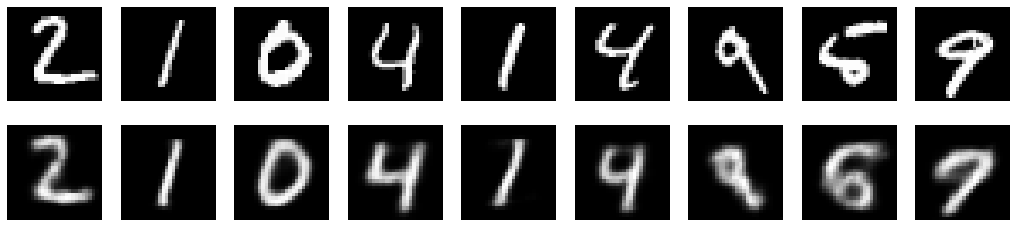

In [31]:
import matplotlib.pyplot as plt

decoded_imgs = vae.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(size, size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(size, size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
import matplotlib.pyplot as plt

decoded_imgs = vae.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(size, size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(size, size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
"""Save models"""

from google.colab import files

# serialize model to JSON
model_json = head_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
files.download('model.json') 
    
# serialize weights to HDF5
head_model.save_weights("model.h5")
files.download('model.h5')

print("Saved model to disk")

In [0]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)

In [0]:
encoded = encoder.predict(x_valid)
print(encoded.shape)
kmeans.fit(encoded)

In [0]:
labels = kmeans.fit_predict(encoded)

In [0]:
with open('proj_out_vals.tsv', 'w') as f:
    for i in range(len(encoded)):
        row = '\t'.join([str(x) for x in encoded[i, :].tolist()]) + '\n'
        f.write(row)


with open('proj_out_labs.tsv', 'w') as f:
    for i in range(len(labels)):
        row = '{}\n'.format(str(labels[i]))
        f.write(row)